<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W1D5/tutorials/W1D5_DimensionalityReduction/W1D5_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 1, Day 5, Tutorial 3
# Dimensionality Reduction and reconstruction

__Content creators:__ Alex Cayco Gajic, John Murray

__Content reviewers:__ Roozbeh Farhoudi, Matt Krause, Spiros Chavlis, Richard Gao, Michael Waskom

---
# Tutorial Objectives

In this notebook we'll learn to apply PCA for dimensionality reduction, using a classic dataset that is often used to benchmark machine learning algorithms: MNIST. We'll also learn how to use PCA for reconstruction and denoising.

Overview:
- Perform PCA on MNIST
- Calculate the variance explained
- Reconstruct data with different numbers of PCs
- (Bonus) Examine denoising using PCA

You can learn more about MNIST dataset [here](https://en.wikipedia.org/wiki/MNIST_database).

Video available at https://youtube.com/watch?v=oO0bbInoO_0


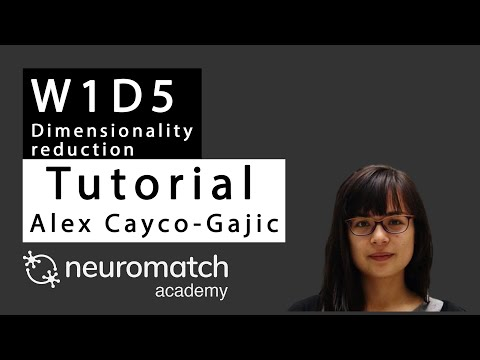

In [1]:
# @title Video 1: PCA for dimensionality reduction
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="oO0bbInoO_0", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

---
# Setup
Run these cells to get the tutorial started.

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# @title Figure Settings
import ipywidgets as widgets   # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [4]:
# @title Helper Functions


def plot_variance_explained(variance_explained):
  """
  Plots eigenvalues.

  Args:
    variance_explained (numpy array of floats) : Vector of variance explained
                                                 for each PC

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(variance_explained) + 1), variance_explained,
           '--k')
  plt.xlabel('Number of components')
  plt.ylabel('Variance explained')
  plt.show()


def plot_MNIST_reconstruction(X, X_reconstructed):
  """
  Plots 9 images in the MNIST dataset side-by-side with the reconstructed
  images.

  Args:
    X (numpy array of floats)               : Data matrix each column
                                              corresponds to a different
                                              random variable
    X_reconstructed (numpy array of floats) : Data matrix each column
                                              corresponds to a different
                                              random variable

  Returns:
    Nothing.
  """

  plt.figure()
  ax = plt.subplot(121)
  k = 0
  for k1 in range(3):
    for k2 in range(3):
      k = k + 1
      plt.imshow(np.reshape(X[k, :], (28, 28)),
                 extent=[(k1 + 1) * 28, k1 * 28, (k2 + 1) * 28, k2 * 28],
                 vmin=0, vmax=255)
  plt.xlim((3 * 28, 0))
  plt.ylim((3 * 28, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.title('Data')
  plt.clim([0, 250])
  ax = plt.subplot(122)
  k = 0
  for k1 in range(3):
    for k2 in range(3):
      k = k + 1
      plt.imshow(np.reshape(np.real(X_reconstructed[k, :]), (28, 28)),
                 extent=[(k1 + 1) * 28, k1 * 28, (k2 + 1) * 28, k2 * 28],
                 vmin=0, vmax=255)
  plt.xlim((3 * 28, 0))
  plt.ylim((3 * 28, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.clim([0, 250])
  plt.title('Reconstructed')
  plt.tight_layout()


def plot_MNIST_sample(X):
  """
  Plots 9 images in the MNIST dataset.

  Args:
     X (numpy array of floats) : Data matrix each column corresponds to a
                                 different random variable

  Returns:
    Nothing.

  """

  fig, ax = plt.subplots()
  k = 0
  for k1 in range(3):
    for k2 in range(3):
      k = k + 1
      plt.imshow(np.reshape(X[k, :], (28, 28)),
                 extent=[(k1 + 1) * 28, k1 * 28, (k2+1) * 28, k2 * 28],
                 vmin=0, vmax=255)
  plt.xlim((3 * 28, 0))
  plt.ylim((3 * 28, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  plt.clim([0, 250])
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()


def plot_MNIST_weights(weights):
  """
  Visualize PCA basis vector weights for MNIST. Red = positive weights,
  blue = negative weights, white = zero weight.

  Args:
     weights (numpy array of floats) : PCA basis vector

  Returns:
     Nothing.
  """

  fig, ax = plt.subplots()
  cmap = plt.cm.get_cmap('seismic')
  plt.imshow(np.real(np.reshape(weights, (28, 28))), cmap=cmap)
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  plt.clim(-.15, .15)
  plt.colorbar(ticks=[-.15, -.1, -.05, 0, .05, .1, .15])
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()


def add_noise(X, frac_noisy_pixels):
  """
  Randomly corrupts a fraction of the pixels by setting them to random values.

  Args:
     X (numpy array of floats)  : Data matrix
     frac_noisy_pixels (scalar) : Fraction of noisy pixels

  Returns:
     (numpy array of floats)    : Data matrix + noise

  """

  X_noisy = np.reshape(X, (X.shape[0] * X.shape[1]))
  N_noise_ixs = int(X_noisy.shape[0] * frac_noisy_pixels)
  noise_ixs = np.random.choice(X_noisy.shape[0], size=N_noise_ixs,
                               replace=False)
  X_noisy[noise_ixs] = np.random.uniform(0, 255, noise_ixs.shape)
  X_noisy = np.reshape(X_noisy, (X.shape[0], X.shape[1]))

  return X_noisy


def change_of_basis(X, W):
  """
  Projects data onto a new basis.

  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

  Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
  """

  Y = np.matmul(X, W)

  return Y


def get_sample_cov_matrix(X):
  """
  Returns the sample covariance matrix of data X.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    (numpy array of floats)   : Covariance matrix
"""

  X = X - np.mean(X, 0)
  cov_matrix = 1 / X.shape[0] * np.matmul(X.T, X)
  return cov_matrix


def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    :   Vector of eigenvalues
    evectors (numpy array of floats) :   Corresponding matrix of eigenvectors
                                         each column corresponds to a different
                                         eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2)*np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]

  return evals, evectors


def pca(X):
  """
  Performs PCA on multivariate data. Eigenvalues are sorted in decreasing order

  Args:
     X (numpy array of floats) :   Data matrix each column corresponds to a
                                   different random variable

  Returns:
    (numpy array of floats)    : Data projected onto the new basis
    (numpy array of floats)    : Vector of eigenvalues
    (numpy array of floats)    : Corresponding matrix of eigenvectors

  """

  X = X - np.mean(X, 0)
  cov_matrix = get_sample_cov_matrix(X)
  evals, evectors = np.linalg.eigh(cov_matrix)
  evals, evectors = sort_evals_descending(evals, evectors)
  score = change_of_basis(X, evectors)

  return score, evectors, evals


def plot_eigenvalues(evals, limit=True):
  """
  Plots eigenvalues.

  Args:
     (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')
  if limit:
    plt.show()

---
# Section 1: Perform PCA on MNIST

The MNIST dataset consists of a 70,000 images of individual handwritten digits. Each image is a 28x28 pixel grayscale image. For convenience, each 28x28 pixel image is often unravelled into a single 784 (=28*28) element vector, so that the whole dataset is represented as a 70,000 x 784 matrix. Each row represents a different image, and each column represents a different pixel.
 
Enter the following cell to load the MNIST dataset and plot the first nine images.

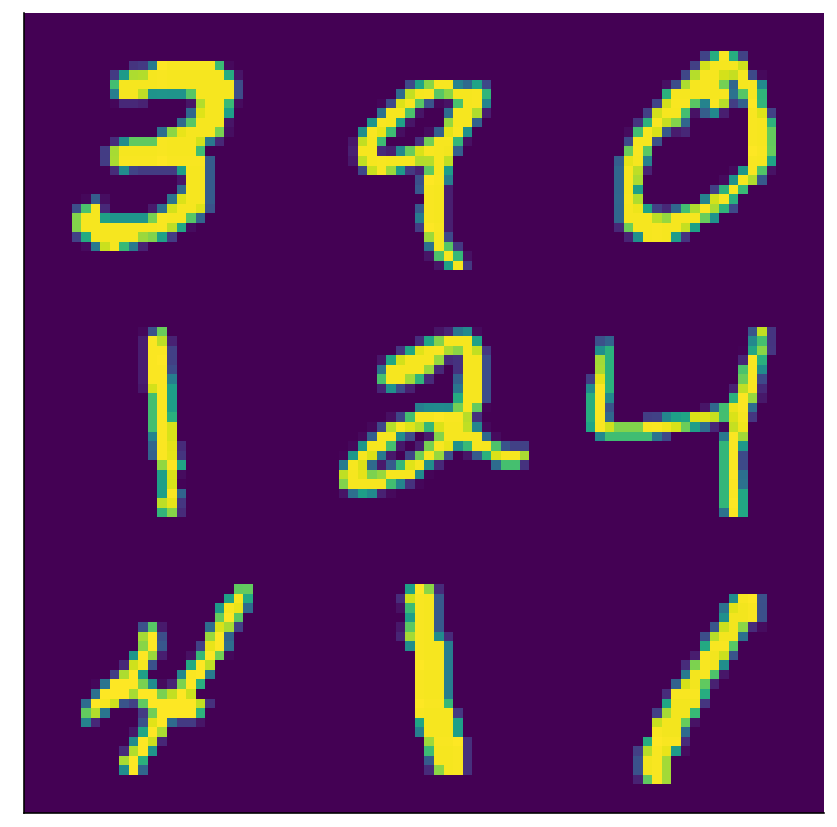

In [5]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml(name='mnist_784')
X = mnist.data
plot_MNIST_sample(X)

The MNIST dataset has an extrinsic dimensionality of 784, much higher than the 2-dimensional examples used in the previous tutorials! To make sense of this data, we'll use dimensionality reduction. But first, we need to determine the intrinsic dimensionality $K$ of the data. One way to do this is to look for an "elbow" in the scree plot, to determine which eigenvalues are signficant.

## Exercise 1: Scree plot of MNIST

In this exercise you will examine the scree plot in the MNIST dataset.

**Steps:**
- Perform PCA on the dataset and examine the scree plot. 
- When do the eigenvalues appear (by eye) to reach zero? (**Hint:** use `plt.xlim` to zoom into a section of the plot).


In [6]:
help(pca)
help(plot_eigenvalues)

Help on function pca in module __main__:

pca(X)
    Performs PCA on multivariate data. Eigenvalues are sorted in decreasing order
    
    Args:
       X (numpy array of floats) :   Data matrix each column corresponds to a
                                     different random variable
    
    Returns:
      (numpy array of floats)    : Data projected onto the new basis
      (numpy array of floats)    : Vector of eigenvalues
      (numpy array of floats)    : Corresponding matrix of eigenvectors

Help on function plot_eigenvalues in module __main__:

plot_eigenvalues(evals, limit=True)
    Plots eigenvalues.
    
    Args:
       (numpy array of floats) : Vector of eigenvalues
    
    Returns:
      Nothing.



In [7]:
#################################################
## TO DO for students: perform PCA and plot the eigenvalues
#################################################

# perform PCA
# score, evectors, evals = ...
# plot the eigenvalues
# plot_eigenvalues(evals, limit=False)
# plt.xlim(...)  # limit x-axis up to 100 for zooming

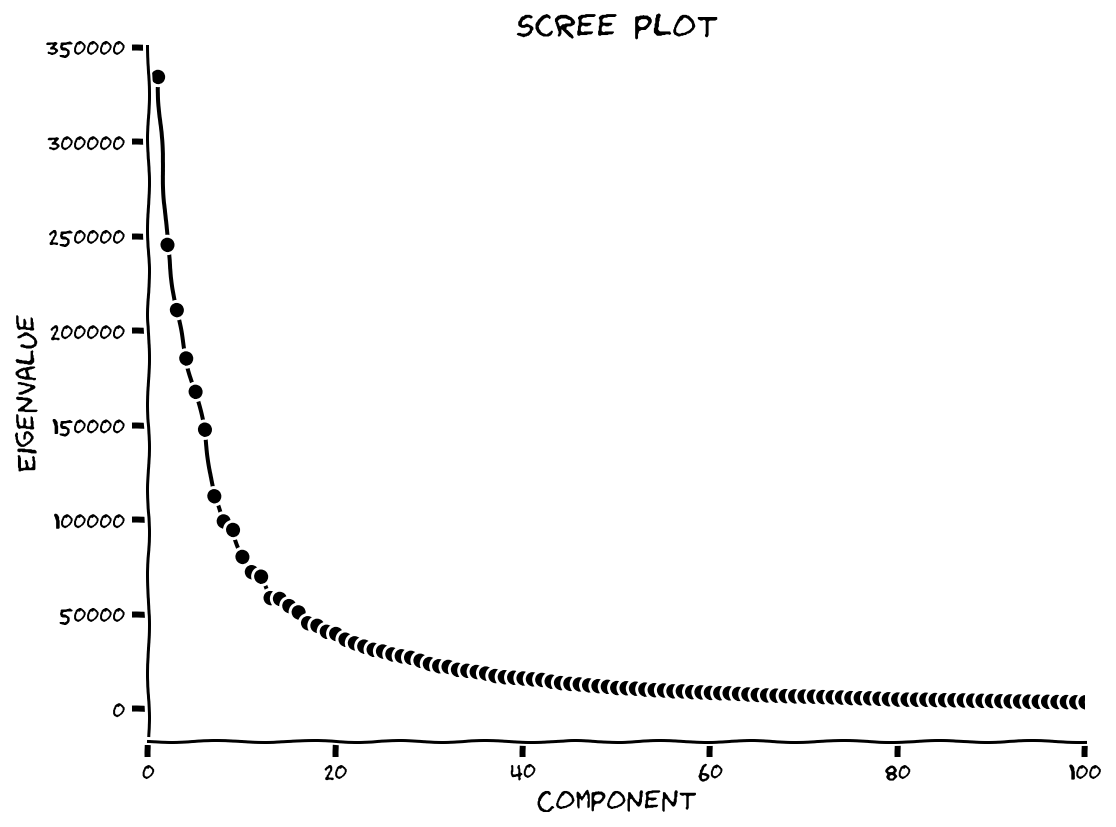

In [8]:
# to_remove solution
# perform PCA
score, evectors, evals = pca(X)

# plot the eigenvalues
with plt.xkcd():
  plot_eigenvalues(evals, limit=False)
  plt.xlim([0, 100])  # limit x-axis up to 100 for zooming

---
# Section 2: Calculate the variance explained

The scree plot suggests that most of the eigenvalues are near zero, with fewer than 100 having large values. Another common way to determine the intrinsic dimensionality is by considering the variance explained. This can be examined with a cumulative plot of the fraction of the total variance explained by the top $K$ components, i.e.,

\begin{equation}
\text{var explained} = \frac{\sum_{i=1}^K \lambda_i}{\sum_{i=1}^N \lambda_i}
\end{equation}

The intrinsic dimensionality is often quantified by the $K$ necessary to explain a large proportion of the total variance of the data (often a defined threshold, e.g., 90%).

## Exercise 2: Plot the explained variance

In this exercise you will plot the explained variance.

**Steps:**
- Fill in the function below to calculate the fraction variance explained as a function of the number of principal componenets. **Hint:** use `np.cumsum`.
- Plot the variance explained using `plot_variance_explained`.

**Questions:**
- How many principal components are required to explain 90% of the variance?
- How does the intrinsic dimensionality of this dataset compare to its extrinsic dimensionality?


In [9]:
help(plot_variance_explained)

Help on function plot_variance_explained in module __main__:

plot_variance_explained(variance_explained)
    Plots eigenvalues.
    
    Args:
      variance_explained (numpy array of floats) : Vector of variance explained
                                                   for each PC
    
    Returns:
      Nothing.



In [10]:
def get_variance_explained(evals):
  """
  Calculates variance explained from the eigenvalues.

  Args:
    evals (numpy array of floats) : Vector of eigenvalues

  Returns:
    (numpy array of floats)       : Vector of variance explained

  """

  #################################################
  ## TO DO for students: calculate the explained variance using the equation
  ## from Section 2.
  # Comment once you've filled in the function
  raise NotImplementedError("Student excercise: calculate explaine variance!")
  #################################################

  # cumulatively sum the eigenvalues
  csum = ...
  # normalize by the sum of eigenvalues
  variance_explained = ...

  return variance_explained


#################################################
## TO DO for students: call the function and plot the variance explained
#################################################

# calculate the variance explained
variance_explained = ...

# Uncomment to plot the variance explained
# plot_variance_explained(variance_explained)

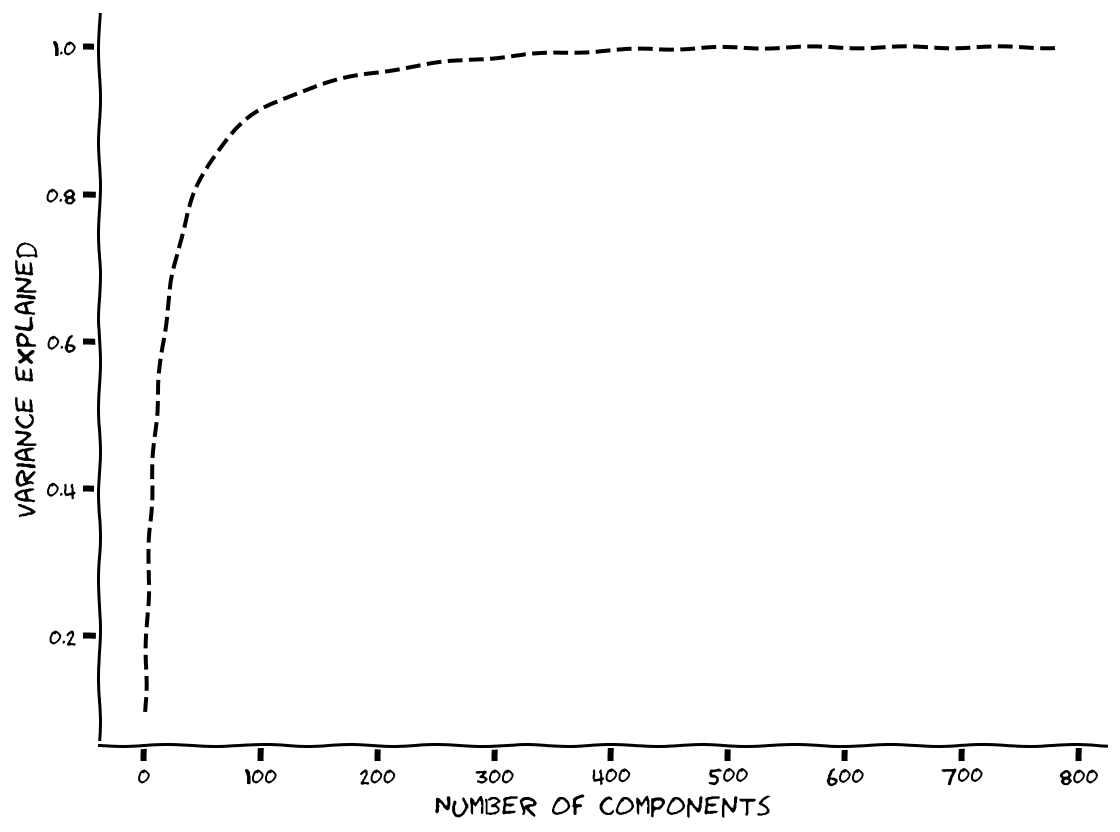

In [11]:
# to_remove solution
def get_variance_explained(evals):
  """
  Plots eigenvalues.

  Args:
    (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """

  # cumulatively sum the eigenvalues
  csum = np.cumsum(evals)
  # normalize by the sum of eigenvalues
  variance_explained = csum / np.sum(evals)

  return variance_explained


# calculate the variance explained
variance_explained = get_variance_explained(evals)
with plt.xkcd():
  plot_variance_explained(variance_explained)

---
# Section 3: Reconstruct data with different numbers of PCs


Video available at https://youtube.com/watch?v=ZCUhW26AdBQ


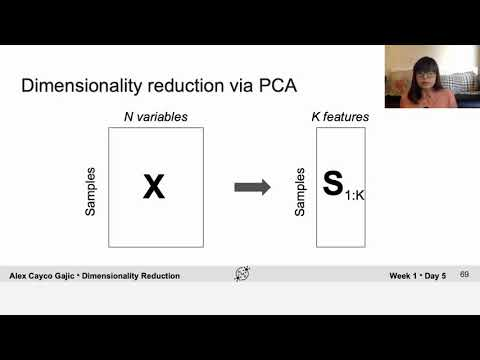

In [12]:
# @title Video 2: Data Reconstruction
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="ZCUhW26AdBQ", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Now we have seen that the top 100 or so principal components of the data can explain most of the variance. We can use this fact to perform *dimensionality reduction*, i.e., by storing the data using only 100 components rather than the samples of all 784 pixels. Remarkably, we will be able to reconstruct much of the structure of the data using only the top 100 components. To see this, recall that to perform PCA we projected the data $\bf X$ onto the eigenvectors of the covariance matrix:
\begin{equation}
\bf S = X W
\end{equation}
Since $\bf W$ is an orthogonal matrix, ${\bf W}^{-1} = {\bf W}^T$. So by multiplying by ${\bf W}^T$ on each side we can rewrite this equation as  
\begin{equation}
{\bf X = S W}^T.
\end{equation}
This now gives us a way to reconstruct the data matrix from the scores and loadings. To reconstruct the data from a low-dimensional approximation, we just have to truncate these matrices.  Let's call ${\bf S}_{1:K}$ and ${\bf W}_{1:K}$ as keeping only the first $K$ columns of this matrix. Then our reconstruction is:
\begin{equation}
{\bf \hat X = S}_{1:K} ({\bf W}_{1:K})^T.
\end{equation}


## Exercise 3: Data reconstruction

Fill in the function below to reconstruct the data using different numbers of principal components. 

**Steps:**

* Fill in the following function to reconstruct the data based on the weights and scores. Don't forget to add the mean!
* Make sure your function works by reconstructing the data with all $K=784$ components. The two images should look identical.

In [13]:
help(plot_MNIST_reconstruction)

Help on function plot_MNIST_reconstruction in module __main__:

plot_MNIST_reconstruction(X, X_reconstructed)
    Plots 9 images in the MNIST dataset side-by-side with the reconstructed
    images.
    
    Args:
      X (numpy array of floats)               : Data matrix each column
                                                corresponds to a different
                                                random variable
      X_reconstructed (numpy array of floats) : Data matrix each column
                                                corresponds to a different
                                                random variable
    
    Returns:
      Nothing.



In [14]:
def reconstruct_data(score, evectors, X_mean, K):
  """
  Reconstruct the data based on the top K components.

  Args:
    score (numpy array of floats)    : Score matrix
    evectors (numpy array of floats) : Matrix of eigenvectors
    X_mean (numpy array of floats)   : Vector corresponding to data mean
    K (scalar)                       : Number of components to include

  Returns:
    (numpy array of floats)          : Matrix of reconstructed data

  """

  #################################################
  ## TO DO for students: Reconstruct the original data in X_reconstructed
  # Comment once you've filled in the function
  raise NotImplementedError("Student excercise: reconstructing data function!")
  #################################################

  # Reconstruct the data from the score and eigenvectors
  # Don't forget to add the mean!!
  X_reconstructed =  ...

  return X_reconstructed


K = 784

#################################################
## TO DO for students: Calculate the mean and call the function, then plot
## the original and the recostructed data
#################################################

# Reconstruct the data based on all components
X_mean = ...
X_reconstructed = ...

# Plot the data and reconstruction
# plot_MNIST_reconstruction(X, X_reconstructed)

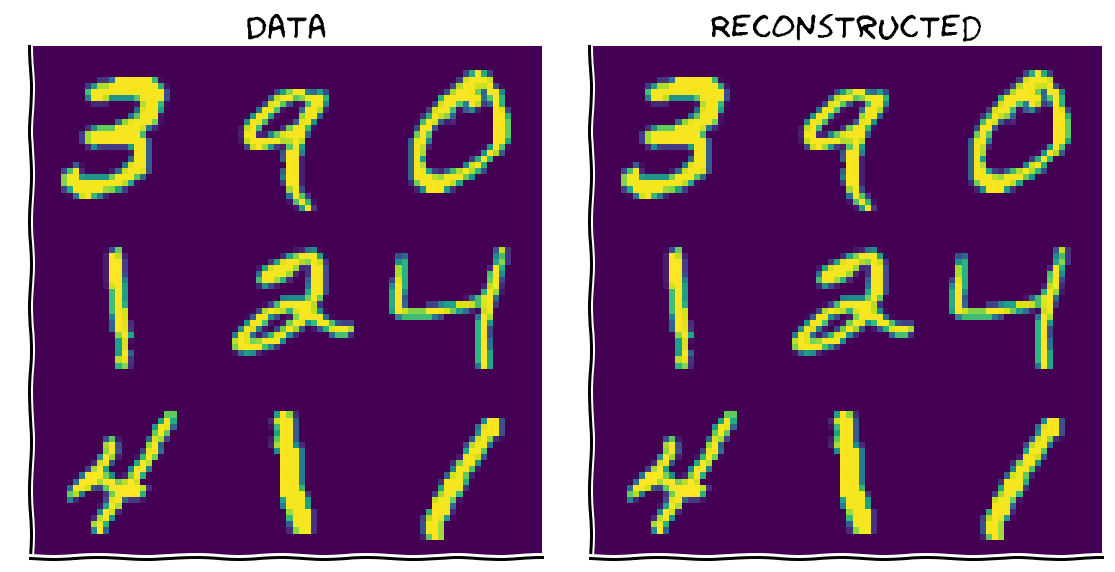

In [15]:
# to_remove solution
def reconstruct_data(score, evectors, X_mean, K):
  """
  Reconstruct the data based on the top K components.

  Args:
    score (numpy array of floats)    : Score matrix
    evectors (numpy array of floats) : Matrix of eigenvectors
    X_mean (numpy array of floats)   : Vector corresponding to data mean
    K (scalar)                       : Number of components to include

  Returns:
    (numpy array of floats)          : Matrix of reconstructed data

  """

  # Reconstruct the data from the score and eigenvectors
  # Don't forget to add the mean!!
  X_reconstructed =  np.matmul(score[:, :K], evectors[:, :K].T) + X_mean

  return X_reconstructed


K = 784

# Reconstruct the data based on all components
X_mean = np.mean(X, 0)
X_reconstructed = reconstruct_data(score, evectors, X_mean, K)

# Plot the data and reconstruction
with plt.xkcd():
  plot_MNIST_reconstruction(X, X_reconstructed)

## Interactive Demo: Reconstruct the data matrix using different numbers of PCs

Now run the code below and experiment with the slider to reconstruct the data matrix using different numbers of principal components.

**Steps**
* How many principal components are necessary to reconstruct the numbers (by eye)? How does this relate to the intrinsic dimensionality of the data?
* Do you see any information in the data with only a single principal component?

In [16]:
# @title

# @markdown Make sure you execute this cell to enable the widget!


def refresh(K=100):
  X_reconstructed = reconstruct_data(score, evectors, X_mean, K)
  plot_MNIST_reconstruction(X, X_reconstructed)
  plt.title('Reconstructed, K={}'.format(K))


_ = widgets.interact(refresh, K=(1, 784, 10))

interactive(children=(IntSlider(value=100, description='K', max=784, min=1, step=10), Output()), _dom_classes=…

## Exercise 4: Visualization of the weights

Next, let's take a closer look at the first principal component by visualizing its corresponding weights. 

**Steps:**

* Enter `plot_MNIST_weights` to visualize the weights of the first basis vector.
* What structure do you see? Which pixels have a strong positive weighting? Which have a strong negative weighting? What kinds of images would this basis vector differentiate?
* Try visualizing the second and third basis vectors. Do you see any structure? What about the 100th basis vector? 500th? 700th?

In [17]:
help(plot_MNIST_weights)

Help on function plot_MNIST_weights in module __main__:

plot_MNIST_weights(weights)
    Visualize PCA basis vector weights for MNIST. Red = positive weights,
    blue = negative weights, white = zero weight.
    
    Args:
       weights (numpy array of floats) : PCA basis vector
    
    Returns:
       Nothing.



In [18]:
#################################################
## TO DO for students: plot the weights calling the plot_MNIST_weights function
#################################################

# Plot the weights of the first principal component
# plot_MNIST_weights(...)

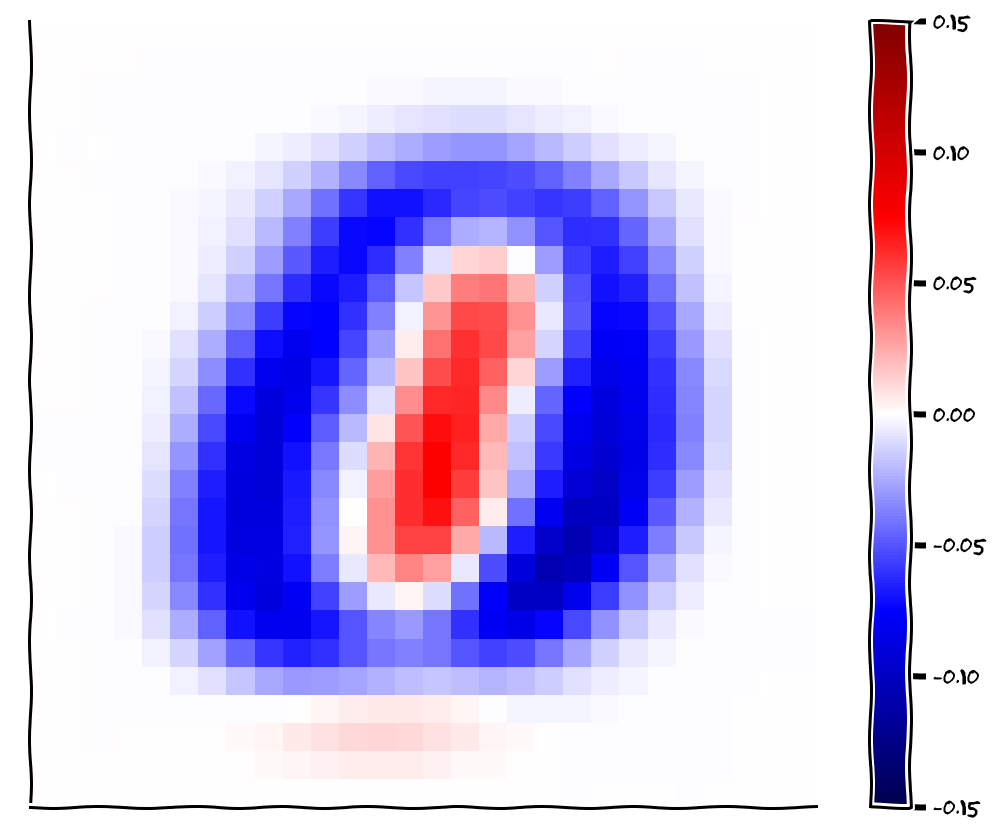

In [19]:
# to_remove solution
# Plot the weights of the first principal component
with plt.xkcd():
  plot_MNIST_weights(evectors[:, 0])

---
# Summary
* In this tutorial, we learned how to use PCA for dimensionality reduction by selecting the top principal components. This can be useful as the intrinsic dimensionality ($K$) is often less than the extrinsic dimensionality ($N$) in neural data. $K$ can be inferred by choosing the number of eigenvalues necessary to capture some fraction of the variance.
* We also learned how to reconstruct an approximation of the original data using the top $K$ principal components. In fact, an alternate formulation of PCA is to find the $K$ dimensional space that minimizes the reconstruction error.
* Noise tends to inflate the apparent intrinsic dimensionality, however the higher components reflect noise rather than new structure in the data. PCA can be used for denoising data by removing noisy higher components.
* In MNIST, the weights corresponding to the first principal component appear to discriminate between a 0 and 1. We will discuss the implications of this for data visualization in the following tutorial.

---
# Bonus: Examine denoising using PCA

In this lecture, we saw that PCA finds an optimal low-dimensional basis to minimize the reconstruction error. Because of this property, PCA can be useful for denoising corrupted samples of the data.

## Exercise 5: Add noise to the data
In this exercise you will add salt-and-pepper noise to the original data and see how that affects the eigenvalues. 

**Steps:**
- Use the function `add_noise` to add noise to 20% of the pixels.
- Then, perform PCA and plot the variance explained. How many principal components are required to explain 90% of the variance? How does this compare to the original data? 


In [20]:
help(add_noise)

Help on function add_noise in module __main__:

add_noise(X, frac_noisy_pixels)
    Randomly corrupts a fraction of the pixels by setting them to random values.
    
    Args:
       X (numpy array of floats)  : Data matrix
       frac_noisy_pixels (scalar) : Fraction of noisy pixels
    
    Returns:
       (numpy array of floats)    : Data matrix + noise



In [21]:
###################################################################
# Insert your code here to:
# Add noise to the data
# Plot noise-corrupted data
# Perform PCA on the noisy data
# Calculate and plot the variance explained
###################################################################
np.random.seed(2020)  # set random seed
X_noisy = ...
# score_noisy, evectors_noisy, evals_noisy = ...
# variance_explained_noisy = ...
# plot_MNIST_sample(X_noisy)
# plot_variance_explained(variance_explained_noisy)

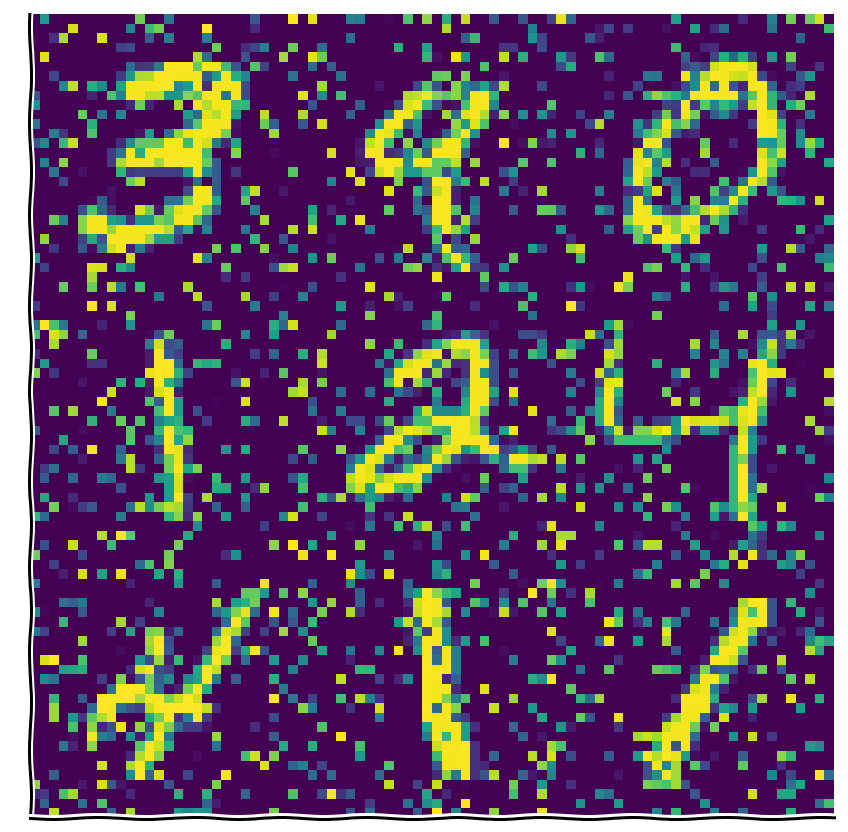

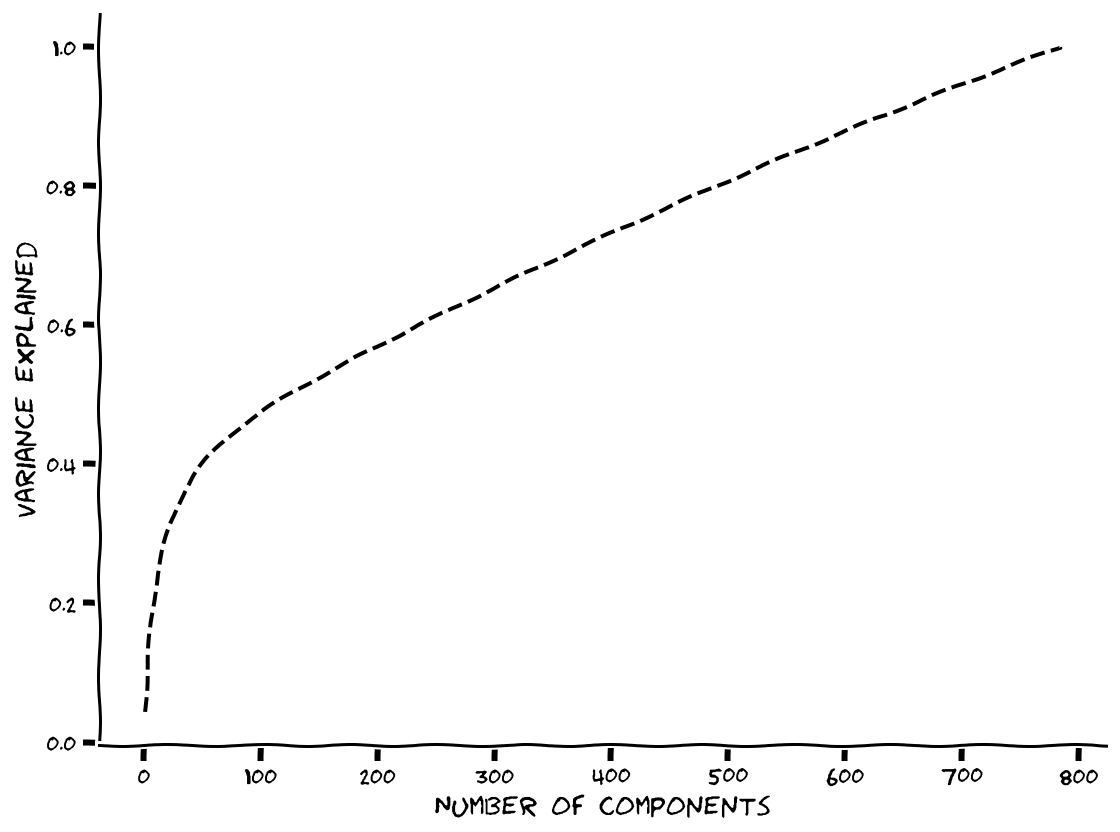

In [22]:
# to_remove solution

np.random.seed(2020)  # set random seed
X_noisy = add_noise(X, .2)
score_noisy, evectors_noisy, evals_noisy = pca(X_noisy)
variance_explained_noisy = get_variance_explained(evals_noisy)

with plt.xkcd():
  plot_MNIST_sample(X_noisy)
  plot_variance_explained(variance_explained_noisy)

## Exercise 6: Denoising

Next, use PCA to perform denoising by projecting the noise-corrupted data onto the basis vectors found from the original dataset. By taking the top K components of this projection, we can reduce noise in dimensions orthogonal to the K-dimensional latent space. 

**Steps:**
- Subtract the mean of the noise-corrupted data.
- Project the data onto the basis found with the original dataset (`evectors`, not `evectors_noisy`) and take the top $K$ components. 
- Reconstruct the data as normal, using the top 50 components. 
- Play around with the amount of noise and K to build intuition.


In [23]:
###################################################################
# Insert your code here to:
# Subtract the mean of the noise-corrupted data
# Project onto the original basis vectors evectors
# Reconstruct the data using the top 50 components
# Plot the result
###################################################################

X_noisy_mean = ...
projX_noisy = ...
X_reconstructed = ...
# plot_MNIST_reconstruction(X_noisy, X_reconstructed)

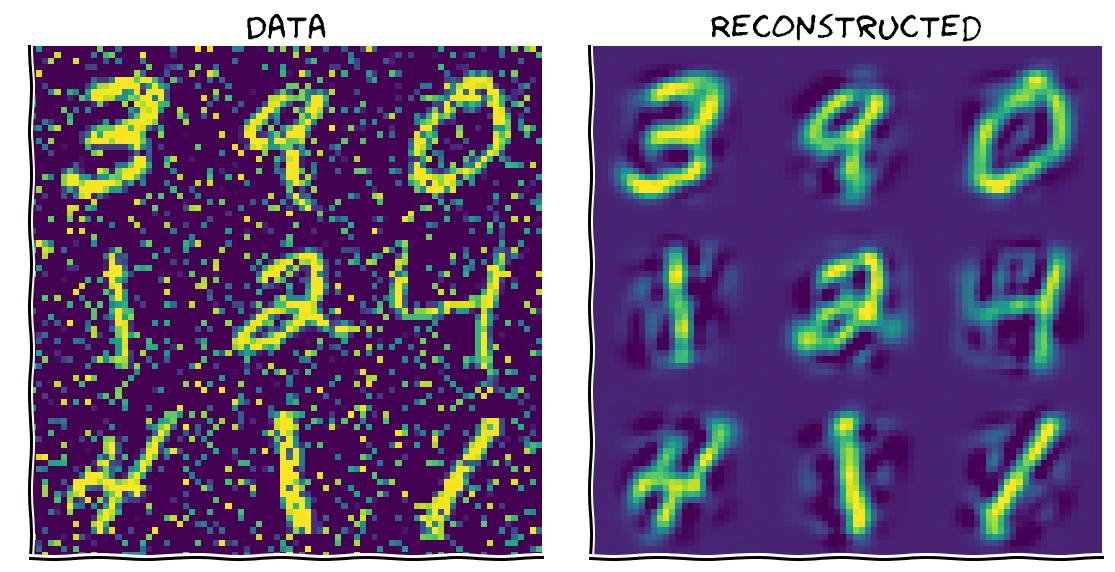

In [24]:
# to_remove solution

X_noisy_mean = np.mean(X_noisy, 0)
projX_noisy = np.matmul(X_noisy - X_noisy_mean, evectors)
X_reconstructed = reconstruct_data(projX_noisy, evectors, X_noisy_mean, 50)

with plt.xkcd():
  plot_MNIST_reconstruction(X_noisy, X_reconstructed)